In [64]:
import os
import sys
import glob
import pickle
import itertools
import random

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.stats import norm

from flowMP import *

random.seed(1234)
%matplotlib inline

## Flow Cytometry Data

Load AML dataset from [ACDC paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5447237/pdf/btx054.pdf)...

In [114]:
# load AML data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

np.random.seed(1234)
#PATH = '/home/disij/projects/acdc/data/'
PATH = '/Users/disiji/Dropbox/current/flow_cytometry/acdc/data/'

### LOAD DATA ###
path = PATH + 'AML_benchmark/'
df = pd.read_csv( path + 'AML_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)
print table.shape

### PROCESS: discard ungated events ###
df = df[df.cell_type != 'NotGated']
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)
channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']

table = table.fillna(0)
X = df[channels].values
table_headers = list(table)
# df2 = pd.DataFrame([[0]*table.shape[1]], columns=table.columns, index =['unknown'])
# table = table.append(df2)

### transform data
data = np.arcsinh((X-1.)/5.)
theta_space = np.array([[data[:,d].min(), data[:,d].max()] for d in range(data.shape[1])])


cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
Y = np.array([cell_type_name2idx[_] for _ in df.cell_type])

print data.shape

(14, 32)
(104184, 32)


## Experiment #1: 2D Simulation

Let's now test out the idea on a 2D subset of the data: the *CD4* and *CD8* features.

In [37]:
data_2d = np.hstack([data[:,5][np.newaxis].T, data[:,6][np.newaxis].T])
np.random.shuffle(data_2d)
data_2d = data_2d[:1000,:]
table_2d = table[['CD4','CD8']]

data_2d_shifted = np.copy(data_2d)
data_2d_shifted += np.array([1,1])
samples_2d = [data_2d, data_2d_shifted]


data_ranges = np.array([[samples_2d[_][:,0].min(), samples_2d[_][:,1].min(), 
                         samples_2d[_][:,0].max(), samples_2d[_][:,1].max()] 
                        for _ in range(len(samples_2d))])
x_min, y_min, x_max, y_max = data_ranges[:,0].min(), data_ranges[:,1].min(), \
                            data_ranges[:,2].max(),data_ranges[:,3].max()
theta_space_2d = np.array([[x_min, x_max], [y_min, y_max]])
n_samples = 2

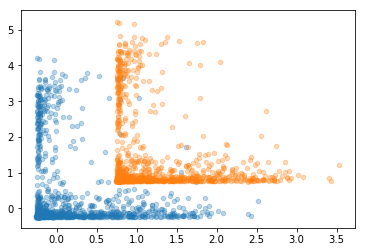

In [47]:
plt.scatter(samples_2d[0][:,0],samples_2d[0][:,1],s=20, alpha = 0.3)
plt.scatter(samples_2d[1][:,0],samples_2d[1][:,1],s=20, alpha = 0.3)

In [196]:
def logP_Mondrian_Gaussian_perturbation(indiv_mp,template_mp,stepsize):
    """
    To-do: truncated Gaussian pdf
    """
    if template_mp[1] == None and template_mp[2] == None:
        return 0
    
    # find the dimension and location of first cut in the old_sample
    for _ in range(template_mp[0].shape[0]):
        if template_mp[0][_,1] > template_mp[1][0][_,1]:
            break
    
    dim = _
    pos_template = template_mp[1][0][dim,1]
    pos_indiv = indiv_mp[1][0][dim, 1]
    
    res = norm(pos_template,(template_mp[0][dim,1] - template_mp[0][dim,0])*stepsize).logpdf(pos_indiv)
    
    res += logP_Mondrian_Gaussian_perturbation(indiv_mp[1],template_mp[1],stepsize)
    res += logP_Mondrian_Gaussian_perturbation(indiv_mp[2],template_mp[2],stepsize)
    return res


### function for computing joint probability
def joint_logP_Random_Effect(template_mp, indiv_mp_list, data_list, table, stepsize):
    """
    INPUT:
    template_mp: one mondrian process
    indiv_mp_list: a list of mondrian processes
    data_list: a list of cell*marker np array
    table: +1 -1 0 information
    """
    logP = comp_log_p_prior(template_mp, table, [1 for _ in range(table.shape[1])])
    n_sample = len(data_list)
    for _ in range(n_sample):
        logP += logP_Mondrian_Gaussian_perturbation(indiv_mp_list[_], template_mp, stepsize)
        logP += comp_log_p_sample(indiv_mp_list[_], data_list[_])
    return logP


## a mini MCMC run to initialize Mondrian process with data
def init_mp(theta_space, table, data, n_iter,mcmc_gaussin_std):
    # randomly draw a template mondrian process
    sample = draw_informed_Mondrian(theta_space, table)
    log_p_sample = comp_log_p_sample(sample, pooled_data) + \
                         comp_log_p_prior(sample, table, [1 for _ in range(table.shape[1])])

    for idx in xrange(n_iter):
        new_sample = Mondrian_Gaussian_perturbation(theta_space,sample, mcmc_gaussin_std)
        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(new_sample, data) + \
                            comp_log_p_prior(new_sample, table, [1 for _ in range(table.shape[1])])

        if new_log_p_sample >=  log_p_sample or \
            np.log(np.random.uniform(low=0, high=1.)) <= new_log_p_sample - log_p_sample:
            sample = new_sample
            log_p_sample = new_log_p_sample
    return sample

Now run MCMC to collect posterior samples...

Initializing template mondrian process with pooled data


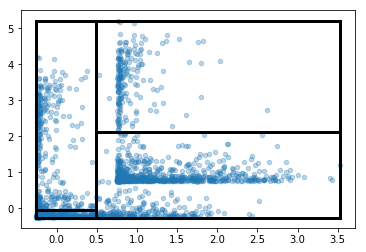

Drawing Chain 0 ...
Drawing Sample 50 ...
Acceptence rate of indiv mp, template mp: 0.06, 0.06, 0.70 
prior probability of the template: -0.41
log likelihood of indiv mp given the template: -29.92, -16.24


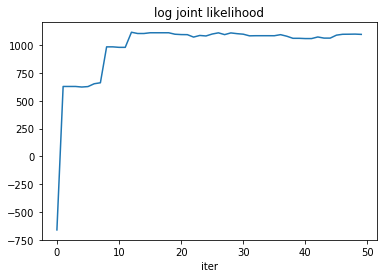

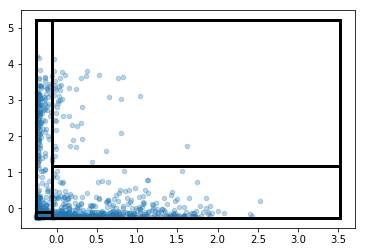

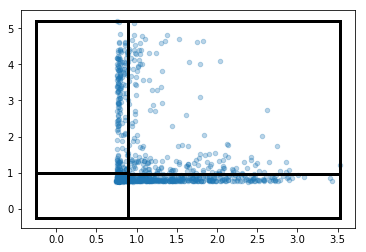

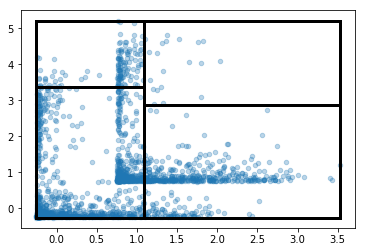

Drawing Sample 100 ...
Acceptence rate of indiv mp, template mp: 0.07, 0.03, 0.67 
prior probability of the template: 0.25
log likelihood of indiv mp given the template: -20.85, -10.53


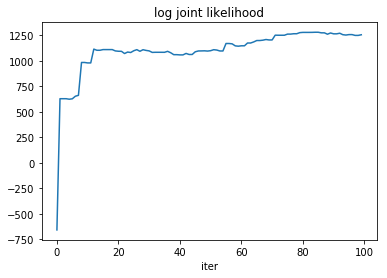

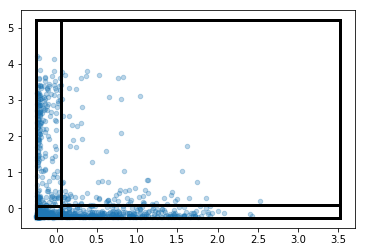

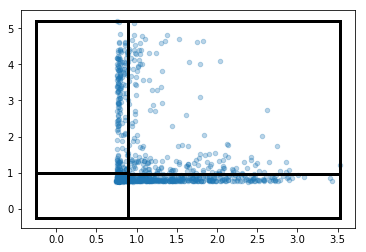

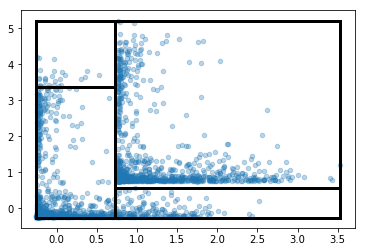

CPU times: user 13.9 s, sys: 162 ms, total: 14.1 s
Wall time: 8.24 s


In [198]:
%%time

n_mcmc_chain = 1
n_mcmc_sample = 100
mcmc_gaussin_std = 0.1

accepte_count_indiv = [0 for _ in range(n_samples)]
accepte_count_template = 0
joint_logP = []

for chain in range(n_mcmc_chain):
    ### INITIALIZE template_mp AND indivi_mp_list
    print "Initializing template mondrian process with pooled data"
    pooled_data = np.concatenate(samples_2d)
    template_mp = init_mp(theta_space_2d, table_2d, pooled_data, 100,mcmc_gaussin_std)
    indiv_mp_list = [np.copy(template_mp) for _ in range(n_samples)] 
    
    plt.scatter(pooled_data[:,0], pooled_data[:,1] ,s=20, alpha = 0.3)
    print_partitions(template_mp)
    plt.show()
    
    if chain % 5 == 0:
        print "Drawing Chain %d ..." % chain
    
    for idx in xrange(n_mcmc_sample):
        
        # update indiv mondrian processes of each sample
        for _ in range(n_samples):
            new_sample = Mondrian_Gaussian_perturbation(
                            theta_space_2d,indiv_mp_list[_], mcmc_gaussin_std)
 
            log_p = joint_logP_Random_Effect(
                        template_mp, [indiv_mp_list[_]],[samples_2d[_]], table_2d, mcmc_gaussin_std)
            new_log_p = joint_logP_Random_Effect(
                        template_mp, [new_sample],[samples_2d[_]], table_2d, mcmc_gaussin_std)
        
            
            if new_log_p >  log_p or \
            np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
                indiv_mp_list[_] = new_sample
                accepte_count_indiv[_] += 1
                
        # update template mondrian process
        new_sample = Mondrian_Gaussian_perturbation(
                    theta_space_2d, template_mp, mcmc_gaussin_std)
        
        log_p = joint_logP_Random_Effect(
                template_mp, indiv_mp_list, np.array([]), table_2d, mcmc_gaussin_std)

        new_log_p = joint_logP_Random_Effect(
                    new_sample, indiv_mp_list, np.array([]), table_2d, mcmc_gaussin_std)
        
        if new_log_p >  log_p or \
        np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
            template_mp = new_sample
            accepte_count_template  +=  1
            
        joint_logP.append(joint_logP_Random_Effect(
                template_mp, indiv_mp_list, samples_2d, table_2d, mcmc_gaussin_std))
        
            
        if (idx + 1) % 50 == 0:
            print "Drawing Sample %d ..." % (idx + 1)
            print "Acceptence rate of indiv mp, template mp: %.2f, %.2f, %.2f " \
                    % (accepte_count_indiv[0]*1.0/(idx+1), accepte_count_indiv[1]*1.0/(idx+1),\
                       accepte_count_template*1.0/(idx+1))
            print "prior probability of the template: %.2f" % \
                    comp_log_p_prior(template_mp, table_2d, [1 for _ in range(table_2d.shape[1])])
            print "log likelihood of indiv mp given the template: %.2f, %.2f" % \
                    ( logP_Mondrian_Gaussian_perturbation(indiv_mp_list[0],template_mp,mcmc_gaussin_std),\
                     logP_Mondrian_Gaussian_perturbation(indiv_mp_list[1],template_mp,mcmc_gaussin_std))
                
                
            plt.plot(joint_logP)
            plt.xlabel("iter")
            plt.title("log joint likelihood")
            plt.show()
            
            plt.scatter(samples_2d[0][:,0], samples_2d[0][:,1],  s=20, alpha=.3)
            print_partitions(indiv_mp_list[0])
            plt.show()

            plt.scatter(samples_2d[1][:,0], samples_2d[1][:,1],  s=20, alpha=.3)
            print_partitions(indiv_mp_list[1])
            plt.show()

            plt.scatter(pooled_data[:,0], pooled_data[:,1] ,s=20, alpha = .3)
            print_partitions(template_mp)
            plt.show()

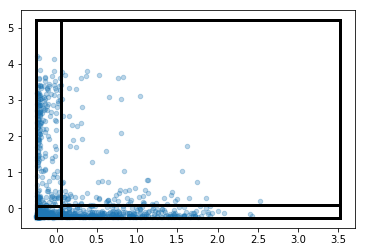

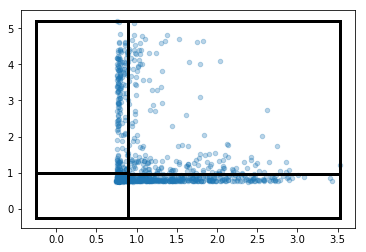

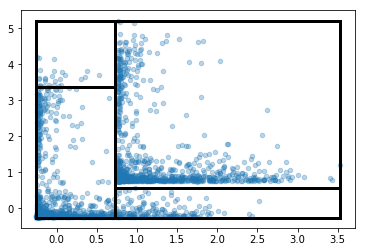

In [199]:
plt.scatter(samples_2d[0][:,0], samples_2d[0][:,1],  s=20, alpha=.3)
print_partitions(indiv_mp_list[0])
plt.show()

plt.scatter(samples_2d[1][:,0], samples_2d[1][:,1],  s=20, alpha=.3)
print_partitions(indiv_mp_list[1])
plt.show()

plt.scatter(pooled_data[:,0], pooled_data[:,1] ,s=20, alpha = .3)
print_partitions(template_mp)